In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2L #480x480
import tensorflow.keras.layers as layers
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.utils import Sequence
from tensorflow.keras import regularizers
import imgaug.augmenters as iaa
import imgaug

from sklearn.model_selection import train_test_split

2023-01-28 14:20:40.790510: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
pd.set_option('display.max_colwidth', None)
#data_dir = '/run/user/1000/gvfs/smb-share:server=titan.local,share=datasets/kitchenware-classification'
data_dir = 'data'
seed = 42

In [3]:
df_train_full = pd.read_csv(data_dir+'/train.csv', dtype={'Id': str})
df_extra = pd.read_csv(data_dir+'/data.csv', dtype={'Id': str})
df_forks = pd.read_csv(data_dir+'/forks_aug.csv', dtype={'Id': str})
#df_spoons = pd.read_csv(data_dir+'/spoon_aug.csv', dtype={'Id': str})
#df_plates = pd.read_csv(data_dir+'/plate_aug.csv', dtype={'Id': str})
#df_cups = pd.read_csv(data_dir+'/cup_aug.csv', dtype={'Id': str})
df_glasses = pd.read_csv(data_dir+'/glasses_aug.csv', dtype={'Id': str})
df_knife = pd.read_csv(data_dir+'/knife_aug.csv', dtype={'Id': str})
#df_train_full = pd.concat([df_train_full, df_extra, df_forks, df_spoons, df_plates, df_cups, df_glasses], ignore_index = True)
df_train_full = pd.concat([df_train_full, df_extra, df_forks, df_glasses, df_knife], ignore_index = True)
df_train_full['filename'] = data_dir+'/images/' + df_train_full['Id'] + '.jpg'
df_train_full = df_train_full.sample(frac = 1, random_state = seed)
df_train_full.reset_index(drop = True, inplace = True)
df_train_full.head()

,Id,label,filename
0,glass_aug_240,glass,data/images/glass_aug_240.jpg
1,3479,glass,data/images/3479.jpg
2,7735,fork,data/images/7735.jpg
3,6366,spoon,data/images/6366.jpg
4,fork_aug_752,fork,data/images/fork_aug_752.jpg


In [4]:
df_train_full.label.value_counts()

plate    1698
cup      1625
knife    1607
glass    1570
fork     1552
spoon    1512
Name: label, dtype: int64

In [5]:
#df_forks

In [6]:
image_width = 480
image_height = 480
NUM_CLASSES = 6
batch_size = 32

In [7]:
df_train, df_val, y_train, y_val = train_test_split(df_train_full, df_train_full['label'], test_size = 0.2, shuffle = True, stratify = df_train_full['label'], random_state = seed)
df_train

,Id,label,filename
5963,eu.ce9f2538-f0d9-461d-85dd-f6be393aa3da,cup,data/images/eu.ce9f2538-f0d9-461d-85dd-f6be393aa3da.jpg
7157,6330,glass,data/images/6330.jpg
3670,5824,plate,data/images/5824.jpg
8945,eu.91274307-90eb-4bb5-98e6-8caaee7c7bb5,cup,data/images/eu.91274307-90eb-4bb5-98e6-8caaee7c7bb5.jpg
9052,8066,cup,data/images/8066.jpg
...,...,...,...
9207,1831,spoon,data/images/1831.jpg
6584,8040,spoon,data/images/8040.jpg
82,3578,spoon,data/images/3578.jpg
7607,knife_aug_12,knife,data/images/knife_aug_12.jpg


In [8]:
histories = []
def combine_histories():
    history = {
        "loss": [],
        "val_loss": [],
        "accuracy": [],
        "val_accuracy": []
    }
    for h in histories:
        #print(history.keys())
        for k in history.keys():
            history[k] += h[k]
            #print(h[k])
    return history

In [9]:
def plot_hist(hist):
    #print(hist)
    plt.plot(hist["accuracy"])
    plt.plot(hist["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()
    


In [10]:
def compile_model(model, learning_rate):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    
    return model

In [11]:
def build_model(num_classes, learning_rate):
    
    inputs = layers.Input(shape = (image_width, image_height, 3))
    x=inputs
    model = EfficientNetV2L(include_top=False, input_tensor=x, weights="imagenet")
    #model = EfficientNetB2(include_top=False, input_tensor=x)
    #path_to_weights = "noisy_weights/adv.prop.notop-b2.h5"
    #model.load_weights(path_to_weights, by_name=True)

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.7
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred", kernel_regularizer=regularizers.l2(0.01))(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    
    return compile_model(model, learning_rate)

In [12]:
def unfreeze_model(model, freeze, learning_rate):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = freeze

    #optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    #model.compile(
    #    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    #)
    return compile_model(model, learning_rate)

In [13]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_dataframe(
    df_train,
    x_col='filename',
    y_col='label',
    target_size=(image_width, image_height),
    batch_size=batch_size,
    rescale=1/255.
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_dataframe(
    df_val,
    x_col='filename',
    y_col='label',
    target_size=(image_width, image_height),
    batch_size=batch_size,
    rescale=1/255.,
)

Found 7651 validated image filenames belonging to 6 classes.
Found 1913 validated image filenames belonging to 6 classes.


2023-01-28 14:20:46.640320: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-28 14:20:46.678147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-28 14:20:46.678353: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-28 14:20:46.678735: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Epoch 1/20


2023-01-28 14:21:04.353990: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-01-28 14:21:05.215140: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-28 14:21:05.215558: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-28 14:21:05.215568: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-01-28 14:21:05.216161: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-28 14:21:05.216199: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-01-28 14:21:05.653421: I tensorflow/stream_executor/cuda/c

240/240 [==============================] - 138s 519ms/step - loss: 1.4143 - accuracy: 0.6212 - val_loss: 0.4557 - val_accuracy: 0.9273
Epoch 2/20
240/240 [==============================] - 121s 501ms/step - loss: 0.6595 - accuracy: 0.8379 - val_loss: 0.2801 - val_accuracy: 0.9477
Epoch 3/20
240/240 [==============================] - 120s 501ms/step - loss: 0.5313 - accuracy: 0.8727 - val_loss: 0.2595 - val_accuracy: 0.9540
Epoch 4/20
240/240 [==============================] - 120s 497ms/step - loss: 0.4476 - accuracy: 0.8936 - val_loss: 0.2427 - val_accuracy: 0.9566
Epoch 5/20
240/240 [==============================] - 119s 496ms/step - loss: 0.4084 - accuracy: 0.9048 - val_loss: 0.2301 - val_accuracy: 0.9613
Epoch 6/20
240/240 [==============================] - 120s 498ms/step - loss: 0.3737 - accuracy: 0.9119 - val_loss: 0.2215 - val_accuracy: 0.9629
Epoch 7/20
240/240 [==============================] - 120s 497ms/step - loss: 0.3371 - accuracy: 0.9242 - val_loss: 0.2131 - val_accura

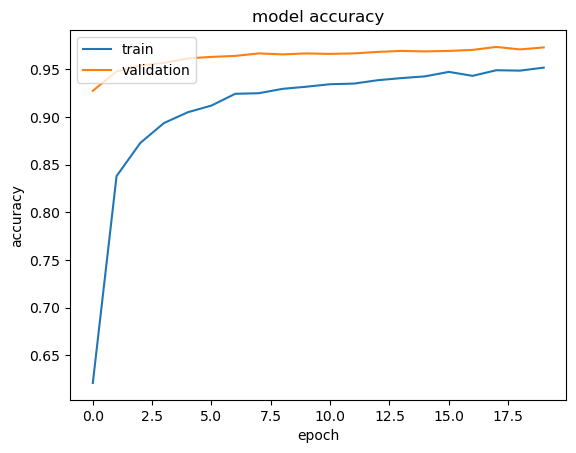

In [14]:
n_epochs = 20
learning_rate=2e-4
model = build_model(num_classes=NUM_CLASSES, learning_rate = learning_rate)

hist = model.fit(
    train_generator,
    epochs=n_epochs,
    validation_data=val_generator
)

histories.append(hist.history)
history = combine_histories()
plot_hist(history)

Epoch 1/3
240/240 [==============================] - 134s 509ms/step - loss: 0.2031 - accuracy: 0.9488 - val_loss: 0.1465 - val_accuracy: 0.9697
Epoch 2/3
240/240 [==============================] - 119s 496ms/step - loss: 0.1886 - accuracy: 0.9518 - val_loss: 0.1421 - val_accuracy: 0.9702
Epoch 3/3
240/240 [==============================] - 119s 497ms/step - loss: 0.2006 - accuracy: 0.9502 - val_loss: 0.1424 - val_accuracy: 0.9718


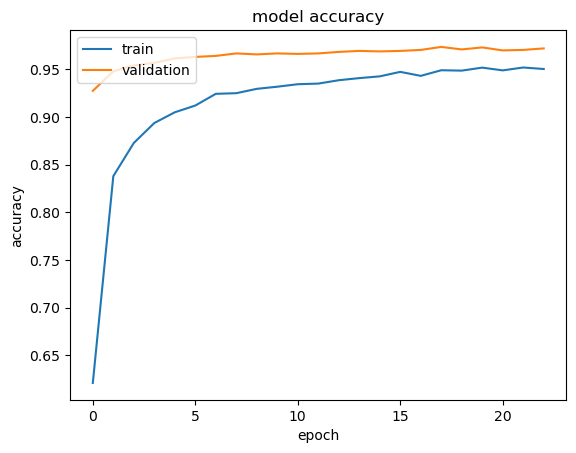

In [15]:
n_epochs = 3
learning_rate = 1e-4
model = compile_model(model, learning_rate)
hist = model.fit(
    train_generator,
    epochs=n_epochs,
    validation_data=val_generator
)

histories.append(hist.history)
history = combine_histories()
plot_hist(history)

In [ ]:
unfreeze_model(model, True, 1e-4)
n_epochs = 3
hist = model.fit(
    train_generator,
    epochs=n_epochs,
    validation_data=val_generator
)

histories.append(hist.history)
history = combine_histories()
plot_hist(history)

In [ ]:
unfreeze_model(model, False, 3e-8)
n_epochs = 3
hist = model.fit(
    train_generator,
    epochs=n_epochs,
    validation_data=val_generator
)

histories.append(hist.history)
history = combine_histories()
plot_hist(history)

In [ ]:
#history.history

In [ ]:
df_test = pd.read_csv(data_dir+'/test.csv', dtype={'Id': str})
df_test['filename'] = data_dir+'/images/' + df_test['Id'] + '.jpg'
df_test.head()

In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='filename',
    class_mode='input',
    target_size=(image_width, image_height),
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
y_pred = model.predict(test_generator)

In [ ]:
classes = np.array(list(train_generator.class_indices.keys()))
classes

In [ ]:
predictions = classes[y_pred.argmax(axis=1)]

In [ ]:
df_submission = pd.DataFrame()
df_submission['filename'] = test_generator.filenames
df_submission['label'] = predictions

df_submission['Id'] = df_submission.filename.str[len(data_dir+'/images/'):-4]
del df_submission['filename']

In [ ]:
df_submission[['Id', 'label']].to_csv('submissions/effv2l_imnet_v9_more_forks_glasses.csv', index=False)

In [ ]:
!kaggle competitions submit kitchenware-classification -f submissions/effv2l_imnet_v9_more_forks_glasses.csv -m 'validation: 0.9770'